In [1]:
# %pip install scipy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from tqdm import tqdm

# import healpy as hp
from scipy.spatial import ConvexHull

import lsst.daf.butler as dafButler

from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, ManualInterval, AsinhStretch, MinMaxInterval, LogStretch


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
config = '/repo/main'
collections = 'LSSTComCam/runs/DRP/DP1/w_2025_03/DM-48478'
collection = 'LSSTComCam/runs/DRP/DP1-RC1/w_2025_02/DM-48371'
butler = dafButler.Butler(config, collections=collections)

In [3]:
bands = ["u", "g", "r", "i", "z", "y"]
verbose = False

for band in bands:
    datasetRefs_dia = butler.query_datasets("goodSeeingDiff_diaObjTable", where=f"band='{band}'")

    if verbose:
        print(f"\nDataset references for band '{band}':")
        for dr in datasetRefs_dia:
            print(dr)

    print(f"Found {len(datasetRefs_dia)} differenceExps for band '{band}'")

Found 581 differenceExps for band 'u'
Found 581 differenceExps for band 'g'
Found 581 differenceExps for band 'r'
Found 581 differenceExps for band 'i'
Found 581 differenceExps for band 'z'
Found 581 differenceExps for band 'y'


In [4]:
lc_refs = butler.query_datasets("diaSourceTable_tract")
obj_refs = butler.query_datasets("diaObjectTable_tract")



print(f"Number of tracts in diaSourceTable (current): {len(lc_refs)}")
print(f"Number of tracts in diaObjectTable_tract (current): {len(obj_refs)}")


Number of tracts in diaSourceTable (current): 28
Number of tracts in diaObjectTable_tract (current): 28


Text(0.5, 1.0, 'Log Number of diaObjects per Number of Sources per Object')

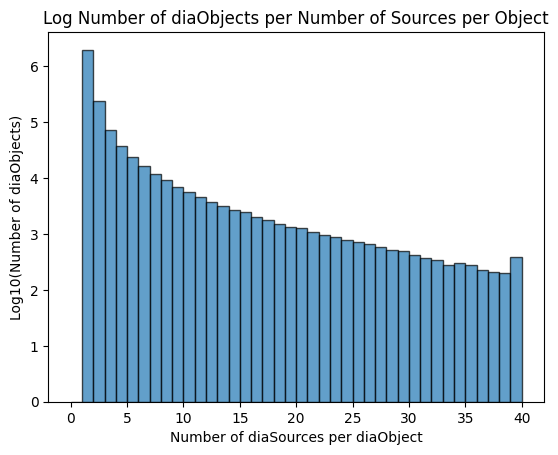

In [5]:
# List of tract indices to process
tract_indices = np.arange(0, len(obj_refs))

# Initialize lists to hold diaObj and diaSource DataFrames
dia_Obj_list = []
diaSource_list = []

# Loop through the specified tracts and fetch the data
for idx in tract_indices:
    obj_ref = obj_refs[idx]  # Select the corresponding obj_ref
    diaObject_tract = butler.get(obj_ref)  # Fetch diaObj for this tract
    diaSource_tract = butler.get('diaSourceTable_tract', dataId=obj_ref.dataId)  # Fetch diaSource for this tract
    
    # Append the results to the lists
    dia_Obj_list.append(diaObject_tract)
    diaSource_list.append(diaSource_tract)

# Concatenate all diaObj and diaSource DataFrames
combined_dia_Obj = pd.concat(dia_Obj_list, ignore_index=False)
combined_diaSource = pd.concat(diaSource_list, ignore_index=False)

# Drop duplicates based on the 'ra' column, keeping the first occurrence
combined_dia_Obj = combined_dia_Obj.drop_duplicates(subset='ra', keep='first')
# Drop duplicates based on the 'ra' column, keeping the first occurrence
combined_diaSource = combined_diaSource.drop_duplicates(subset='ra', keep='first')

diaObject = combined_dia_Obj.copy()
diaSource = combined_diaSource.copy()

# Compute the histogram of nDiaSources
counts, bin_edges = np.histogram(combined_dia_Obj['nDiaSources'], bins=40, range=(0, 40))

# Take the logarithm (base 10) of the counts
log_counts = np.log10(counts + 1)  # Add 1 to avoid log(0)

# Plot the histogram
plt.bar(bin_edges[:-1], log_counts, width=np.diff(bin_edges), align='edge', edgecolor='black', alpha=0.7)
plt.xlabel('Number of diaSources per diaObject')
plt.ylabel('Log10(Number of diaObjects)')
plt.title('Log Number of diaObjects per Number of Sources per Object')

In [6]:
datasetRefs_dia = butler.query_datasets("goodSeeingDiff_diaObjTable")
idx = 50

obj_ref = datasetRefs_dia[idx]  # Select the corresponding obj_ref
diaSrc = butler.get('goodSeeingDiff_diaSrcTable', dataId={'skymap': 'lsst_cells_v1', 'visit': 2024112400120, 'detector': 3})  

# Step 1: Get unique 'ra' values and their counts
uniq_values, counts = np.unique(diaSrc['ra'], return_counts=True)

# Step 2: Separate 'ra' values that appear only once and those that repeat
ra_single = uniq_values[counts == 1]
ra_repeated = uniq_values[counts > 1]

# Step 3: Filter the DataFrame for these values
diaSrc_single = diaSrc[diaSrc['ra'].isin(ra_single)]  # 'ra' appears only once
diaSrc_repeated = diaSrc[diaSrc['ra'].isin(ra_repeated)]  # 'ra' repeats




In [7]:
datasetRefs_dia = butler.query_datasets("goodSeeingDiff_diaObjTable")
idx = 50

obj_ref = datasetRefs_dia[idx]  # Select the corresponding obj_ref
diaObjTable_patch = butler.get('goodSeeingDiff_assocDiaSrcTable', dataId=obj_ref.dataId ) 

# Step 1: Get unique 'ra' values and their counts
uniq_values, counts = np.unique(diaObjTable_patch['ra'], return_counts=True)

# Step 2: Separate 'ra' values that appear only once and those that repeat
ra_single = uniq_values[counts == 1]
ra_repeated = uniq_values[counts > 1]

# Step 3: Filter the DataFrame for these values
diaObj_single = diaObjTable_patch[diaObjTable_patch['ra'].isin(ra_single)]  # 'ra' appears only once
diaObj_repeated = diaObjTable_patch[diaObjTable_patch['ra'].isin(ra_repeated)]  # 'ra' repeats


In [8]:
diaObj_repeated

,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,ra,...,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,coord_ra,coord_dec
diaSourceId,,,,,,,,,,,,,,,,,,,,,
191438297384354224,2024112400120,0,i,199798854952943977,0,0,60639.059419,20,2025-01-19 05:10:22.923704,6.631002,...,False,False,False,False,False,False,False,False,6.630733,-72.549803
191438297384354225,2024112400120,0,i,199798854952944540,0,0,60639.059419,42,2025-01-19 05:10:22.923704,6.631002,...,False,False,False,False,False,False,False,False,6.631163,-72.549791
191860409991430955,2024120600027,0,r,199798854952945069,0,0,60651.058332,20,2025-01-19 04:50:35.935446,6.522248,...,False,False,False,False,False,False,False,False,6.522248,-72.504241
191860409991430956,2024120600027,0,r,199798854952945069,0,0,60651.058332,44,2025-01-19 04:50:35.935446,6.522248,...,False,False,False,False,False,False,False,False,6.522248,-72.504241
191860430392525332,2024120600046,0,r,199798854952945162,0,0,60651.072043,58,2025-01-19 04:51:11.874431,6.469793,...,False,False,False,False,False,False,False,False,6.469793,-72.505235
191860430392525361,2024120600046,0,r,199798854952945162,0,0,60651.072043,58,2025-01-19 04:51:11.874431,6.469793,...,False,False,False,False,False,False,False,False,6.469793,-72.505235
191860430392525365,2024120600046,0,r,199798854952945164,0,0,60651.072043,28,2025-01-19 04:51:11.874431,6.469793,...,False,False,False,False,False,False,False,False,6.469793,-72.505235
191860435761233931,2024120600051,0,g,199798854952943770,0,0,60651.074597,18,2025-01-19 05:24:03.703560,6.689633,...,False,False,False,False,False,False,False,False,6.689456,-72.505206
191860435761233932,2024120600051,0,g,199798854952945261,0,0,60651.074597,48,2025-01-19 05:24:03.703560,6.689633,...,False,False,False,False,False,False,False,False,6.689633,-72.505206


In [9]:
diaSrc[diaSrc['diaSourceId']==191438297384354224][['ra', 'dec']]   

,ra,dec


In [10]:
diaSrc[diaSrc['diaSourceId']==191438297384354225][['ra', 'dec']]   

,ra,dec


In [11]:
diaSrc_repeated

,diaSourceId,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,...,shape_flag_no_pixels,shape_flag_not_contained,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter
951,191438297396937656,2024112400120,3,i,0,0,0,60639.059419,18,2025-01-19 05:22:04.836422,...,False,False,False,False,False,False,False,False,False,False
960,191438297396937665,2024112400120,3,i,0,0,0,60639.059419,40,2025-01-19 05:22:04.836422,...,False,False,False,False,False,False,False,False,False,False


In [12]:
diaSrc_repeated[['pixelFlags', 'pixelFlags_offimage',
       'pixelFlags_edge', 'pixelFlags_interpolated', 'pixelFlags_saturated',
       'pixelFlags_cr', 'pixelFlags_bad', 'pixelFlags_suspect',
       'pixelFlags_interpolatedCenter', 'pixelFlags_saturatedCenter',
       'pixelFlags_crCenter', 'pixelFlags_suspectCenter', 'centroid_flag',
       'apFlux_flag', 'apFlux_flag_apertureTruncated', 'psfFlux_flag',
       'psfFlux_flag_noGoodPixels', 'psfFlux_flag_edge', 'forced_PsfFlux_flag',
       'forced_PsfFlux_flag_noGoodPixels']]

,pixelFlags,pixelFlags_offimage,pixelFlags_edge,pixelFlags_interpolated,pixelFlags_saturated,pixelFlags_cr,pixelFlags_bad,pixelFlags_suspect,pixelFlags_interpolatedCenter,pixelFlags_saturatedCenter,pixelFlags_crCenter,pixelFlags_suspectCenter,centroid_flag,apFlux_flag,apFlux_flag_apertureTruncated,psfFlux_flag,psfFlux_flag_noGoodPixels,psfFlux_flag_edge,forced_PsfFlux_flag,forced_PsfFlux_flag_noGoodPixels
951,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,True,False
960,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,True,False


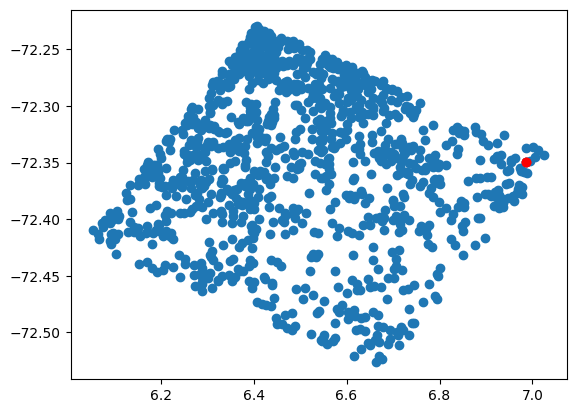

In [13]:
plt.scatter(diaSrc['ra'], diaSrc['dec'], label ='goodSeeingDiff_diaSrcTable')
plt.scatter(diaSrc_repeated['ra'], diaSrc_repeated['dec'], color='red')

In [14]:
diaObj_repeated

,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,ra,...,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,coord_ra,coord_dec
diaSourceId,,,,,,,,,,,,,,,,,,,,,
191438297384354224,2024112400120,0,i,199798854952943977,0,0,60639.059419,20,2025-01-19 05:10:22.923704,6.631002,...,False,False,False,False,False,False,False,False,6.630733,-72.549803
191438297384354225,2024112400120,0,i,199798854952944540,0,0,60639.059419,42,2025-01-19 05:10:22.923704,6.631002,...,False,False,False,False,False,False,False,False,6.631163,-72.549791
191860409991430955,2024120600027,0,r,199798854952945069,0,0,60651.058332,20,2025-01-19 04:50:35.935446,6.522248,...,False,False,False,False,False,False,False,False,6.522248,-72.504241
191860409991430956,2024120600027,0,r,199798854952945069,0,0,60651.058332,44,2025-01-19 04:50:35.935446,6.522248,...,False,False,False,False,False,False,False,False,6.522248,-72.504241
191860430392525332,2024120600046,0,r,199798854952945162,0,0,60651.072043,58,2025-01-19 04:51:11.874431,6.469793,...,False,False,False,False,False,False,False,False,6.469793,-72.505235
191860430392525361,2024120600046,0,r,199798854952945162,0,0,60651.072043,58,2025-01-19 04:51:11.874431,6.469793,...,False,False,False,False,False,False,False,False,6.469793,-72.505235
191860430392525365,2024120600046,0,r,199798854952945164,0,0,60651.072043,28,2025-01-19 04:51:11.874431,6.469793,...,False,False,False,False,False,False,False,False,6.469793,-72.505235
191860435761233931,2024120600051,0,g,199798854952943770,0,0,60651.074597,18,2025-01-19 05:24:03.703560,6.689633,...,False,False,False,False,False,False,False,False,6.689456,-72.505206
191860435761233932,2024120600051,0,g,199798854952945261,0,0,60651.074597,48,2025-01-19 05:24:03.703560,6.689633,...,False,False,False,False,False,False,False,False,6.689633,-72.505206


In [15]:
diaObj_repeated.columns

Index(['visit', 'detector', 'band', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midpointMjdTai', 'bboxSize', 'time_processed',
       'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov', 'x', 'y', 'xErr', 'yErr',
       'apFlux', 'apFluxErr', 'snr', 'psfFlux', 'psfFluxErr', 'psfChi2',
       'psfNdata', 'trailFlux', 'trailRa', 'trailDec', 'trailLength',
       'trailAngle', 'dipoleMeanFlux', 'dipoleMeanFluxErr', 'dipoleFluxDiff',
       'dipoleFluxDiffErr', 'dipoleLength', 'dipoleAngle', 'dipoleChi2',
       'isDipole', 'dipoleFitAttempted', 'dipoleNdata', 'scienceFlux',
       'scienceFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF',
       'extendedness', 'reliability', 'pixelFlags', 'pixelFlags_offimage',
       'pixelFlags_edge', 'pixelFlags_interpolated', 'pixelFlags_saturated',
       'pixelFlags_cr', 'pixelFlags_bad', 'pixelFlags_suspect',
       'pixelFlags_interpolatedCenter', 'pixelFlags_saturatedCenter',
       'pixelFlags_crCenter', 'pixelFlags_suspectCent

In [16]:
plt.scatter(diaSource_single['ra'], diaSource_single['dec'], s=1, label='Single', color='blue')
plt.scatter(diaSource_repeated['ra'], diaSource_repeated['dec'], s=1, label='Single', color='red')

NameError: name 'diaSource_single' is not defined

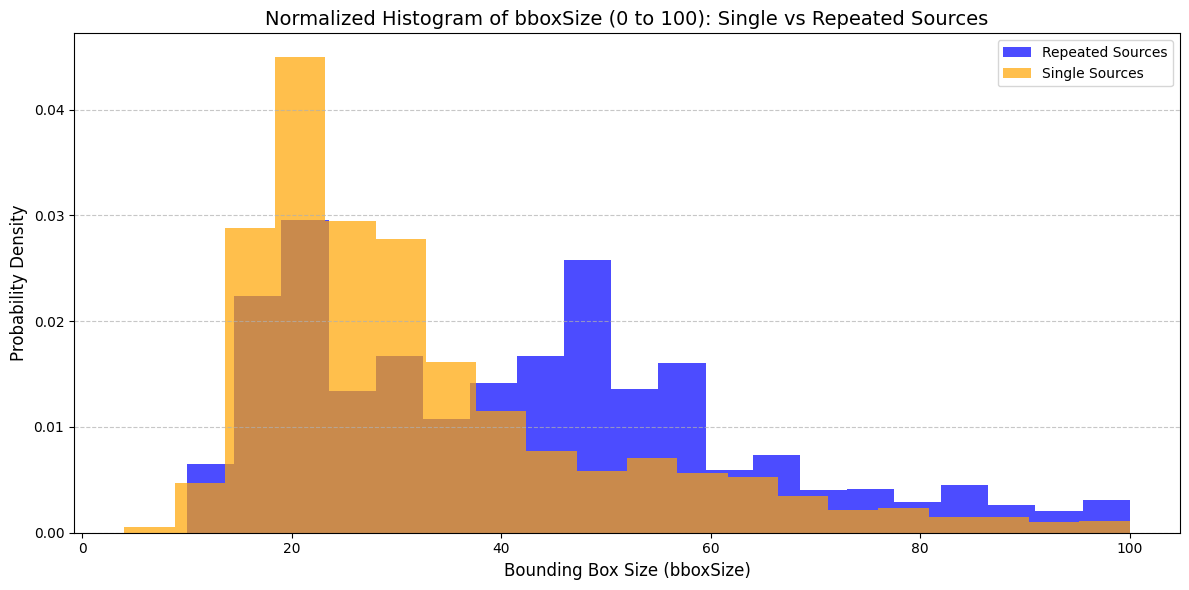

In [142]:
import matplotlib.pyplot as plt

# Filter the data to include only bboxSize between 0 and 100
filtered_repeated = diaSource_repeated[(diaSource_repeated['bboxSize'] >= 0) & (diaSource_repeated['bboxSize'] <= 100)]
filtered_single = diaSource_single[(diaSource_single['bboxSize'] >= 0) & (diaSource_single['bboxSize'] <= 100)]

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot normalized histogram for repeated 'bboxSize'
plt.hist(
    filtered_repeated['bboxSize'], 
    bins=20,  # Adjust bins for better granularity
    alpha=0.7, 
    color='blue', 
    label='Repeated Sources',
    density=True  # Normalize the histogram
)

# Plot normalized histogram for single 'bboxSize'
plt.hist(
    filtered_single['bboxSize'], 
    bins=20, 
    alpha=0.7, 
    color='orange', 
    label='Single Sources',
    density=True  # Normalize the histogram
)

# Add labels, title, and legend
plt.xlabel('Bounding Box Size (bboxSize)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title('Normalized Histogram of bboxSize (0 to 100): Single vs Repeated Sources', fontsize=14)
plt.legend(fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [134]:
np.sum(diaSource_repeated[['centroid_flag']])

centroid_flag    8853
dtype: int64

In [135]:
np.sum(diaSource_single[['centroid_flag']])

centroid_flag    322426
dtype: int64

In [137]:
len(diaSource_single[['centroid_flag']])

634343

In [141]:
np.sum(diaSource_repeated['isDipole'])

np.int64(0)

In [21]:
datasetRefs_dia = butler.query_datasets("goodSeeingDiff_diaSrc")
idx = 50

obj_ref = datasetRefs_dia[idx]  # Select the corresponding obj_ref
goodSeeingDiff_diaSrc = butler.get('goodSeeingDiff_diaSrc', dataId={'skymap': 'lsst_cells_v1', 'visit': 2024112400120, 'detector': 0})  

# Step 1: Get unique 'ra' values and their counts
uniq_values, counts = np.unique(goodSeeingDiff_diaSrc['coord_ra'], return_counts=True)

# Step 2: Separate 'ra' values that appear only once and those that repeat
ra_single = uniq_values[counts == 1]
ra_repeated = uniq_values[counts > 1]

goodSeeingDiff_diaSrc_df = goodSeeingDiff_diaSrc.asAstropy().to_pandas()
# Step 3: Filter the DataFrame for these values
diaSrc_single = goodSeeingDiff_diaSrc_df[goodSeeingDiff_diaSrc_df['coord_ra'].isin(ra_single)]  # 'ra' appears only once
diaSrc_repeated = goodSeeingDiff_diaSrc_df[goodSeeingDiff_diaSrc_df['coord_ra'].isin(ra_repeated)]  # 'ra' repeats



In [19]:
i=170
diaSrc_repeated[['id','coord_ra','coord_dec','slot_Shape_x',	'slot_Shape_y',	 'slot_Shape_xx', 'slot_Shape_yy', 'slot_Shape_xy','ip_diffim_forced_PsfFlux_instFlux', 'ip_diffim_forced_PsfFlux_instFluxErr', 'ip_diffim_forced_PsfFlux_area']]

,id,coord_ra,coord_dec,slot_Shape_x,slot_Shape_y,slot_Shape_xx,slot_Shape_yy,slot_Shape_xy,ip_diffim_forced_PsfFlux_instFlux,ip_diffim_forced_PsfFlux_instFluxErr,ip_diffim_forced_PsfFlux_area
431,191438297384354224,0.115733,-1.266233,95.423085,3845.442490,0.710891,2.706739,0.761921,146637.370563,494.792561,85.161232
432,191438297384354225,0.115733,-1.266233,NaN,NaN,NaN,NaN,NaN,514.679558,494.792561,85.161232
442,191438297384354235,0.107590,-1.264731,3052.224780,3901.637341,1.158169,32.381490,1.571232,-1705.464714,282.532242,75.674561
443,191438297384354236,0.107590,-1.264731,NaN,NaN,NaN,NaN,NaN,1314.884255,282.532242,75.674561
452,191438297384354245,0.107512,-1.264685,3097.152613,3927.127611,2.419346,5.072816,-1.944594,35541.266913,339.233989,75.032074
454,191438297384354247,0.107512,-1.264685,NaN,NaN,NaN,NaN,NaN,522.735896,339.233989,75.032074


In [26]:
# Replace the desired ID value below
desired_id = 191438297384354224

# Filter the SourceCatalog to select the row with the specified ID
record = goodSeeingDiff_diaSrc[goodSeeingDiff_diaSrc['id'] == desired_id]
"""
footprint = record.getFootprint()
print(footprint.peaks)
"""


'\nfootprint = record.getFootprint()\nprint(footprint.peaks)\n'

In [48]:
goodSeeingDiff_diaSrc

<class 'lsst.afw.table.SourceCatalog'>
        id               coord_ra      ... refMatchId srcMatchId
                           rad         ...                      
------------------ ------------------- ... ---------- ----------
191438297384353793  0.1046088947566294 ...          0          0
191438297384353794 0.10321353807698454 ...          0          0
191438297384353795 0.09850324691874845 ...          0          0
191438297384353796 0.10500495751724068 ...          0          0
191438297384353797 0.09886826550853751 ...          0          0
191438297384353798 0.10183268753392154 ...          0          0
191438297384353799 0.09864299169107309 ...          0          0
191438297384353800 0.10770955960328477 ...          0          0
191438297384353801 0.10032354658340865 ...          0          0
               ...                 ... ...        ...        ...
191438297384354255 0.10685939899237536 ...          0          0
191438297384354256 0.10929429438987023 ...         

In [36]:
goodSeeingDiff_diaSrcTable = butler.get('goodSeeingDiff_diaSrcTable', dataId={'skymap': 'lsst_cells_v1', 'visit': 2024112400120, 'detector': 0})  

In [47]:
goodSeeingDiff_diaSrcTable

cat = goodSeeingDiff_diaSrc
for record in cat[:10]:
    footprint = record.getFootprint()
    print(footprint.peaks)

 id  f_x   f_y  i_x  i_y peakValue     significance  
     pix   pix  pix  pix     ct                      
--- ------ ---- ---- --- ---------- -----------------
561 1809.0 16.0 1809  16 -38.707905 5.528388500213623
 id  f_x   f_y  i_x  i_y peakValue     significance  
     pix   pix  pix  pix     ct                      
--- ------ ---- ---- --- ---------- -----------------
  1 2307.0 16.0 2307  16  48.289047 7.057333946228027
562 2301.0 16.0 2301  16 -37.224747  5.34979248046875
 id  f_x   f_y  i_x  i_y peakValue    significance   
     pix   pix  pix  pix     ct                      
--- ------ ---- ---- --- --------- ------------------
  2 4003.0 33.0 4003  33 59.021217 10.404953002929688
563 4004.0 27.0 4004  27 -65.38172  10.85401725769043
 id  f_x   f_y  i_x  i_y peakValue     significance  
     pix   pix  pix  pix     ct                      
--- ------ ---- ---- --- ---------- -----------------
564 1676.0 30.0 1676  30 -81.684685 7.293213844299316
 id  f_x   f_y  i_x  i_y pea

In [ ]:
# Define the desired IDs - two dupliacates here
desired_ids = {191438297384354224, 191438297384354225}

# Filter the SourceCatalog for records with the specified IDs
filtered_records = [record for record in goodSeeingDiff_diaSrc if record['id'] in desired_ids]

# Display the filtered records
for record in filtered_records:
    print(f"Record ID: {record['id']}")
    footprint = record.getFootprint()
    print(f"Footprint Peaks: {footprint.peaks}")
    print("-------------------------------")

Record ID: 191438297384354224
Footprint Peaks:  id   f_x    f_y   i_x  i_y  peakValue    significance   
      pix    pix   pix  pix      ct                      
---- ------ ------ ---- ---- --------- ------------------
1099   96.0 3846.0   96 3846 -42.42569  5.822897434234619
1098 3654.0 3836.0 3654 3836 -74.35252 10.968558311462402
-------------------------------
Record ID: 191438297384354225
Footprint Peaks:  id   f_x   f_y   i_x i_y  peakValue     significance  
      pix   pix   pix pix      ct                      
---- ----- ------ --- ---- ---------- -----------------
1099  96.0 3846.0  96 3846  -42.42569 5.822897434234619
1100 496.0 3847.0 496 3847 -45.525803 5.938525676727295
-------------------------------


In [55]:
footprint.peaks

<class 'lsst.afw.detection.PeakCatalog'>
 id   f_x   f_y   i_x i_y  peakValue     significance  
      pix   pix   pix pix      ct                      
---- ----- ------ --- ---- ---------- -----------------
1099  96.0 3846.0  96 3846  -42.42569 5.822897434234619
1100 496.0 3847.0 496 3847 -45.525803 5.938525676727295

In [159]:
diaSrc_repeated.columns[260:]

Index(['base_InvalidPsf_flag', 'base_PsfFlux_apCorr', 'slot_PsfFlux_apCorr',
       'base_PsfFlux_apCorrErr', 'slot_PsfFlux_apCorrErr',
       'base_PsfFlux_flag_apCorr', 'slot_PsfFlux_flag_apCorr',
       'ip_diffim_forced_PsfFlux_instFlux',
       'ip_diffim_forced_PsfFlux_instFluxErr', 'ip_diffim_forced_PsfFlux_area',
       'ip_diffim_forced_PsfFlux_flag',
       'ip_diffim_forced_PsfFlux_flag_noGoodPixels',
       'ip_diffim_forced_PsfFlux_flag_edge', 'refMatchId', 'srcMatchId'],
      dtype='object')

In [137]:
diaSrc_repeated.shape

(6, 275)

In [ ]:
# Extract the schema fields from the SourceCatalog
fields = goodSeeingDiff_diaSrc.schema.getNames()

# Initialize a list to store row data
data = []

# Iterate through the SourceCatalog and extract values
for record in goodSeeingDiff_diaSrc_repeated:
    row = {field: record.get(field) for field in fields}  # Create a dictionary for each record
    data.append(row)

# Convert the list of dictionaries into a pandas DataFrame
goodSeeingDiff_diaSrc_repeated = pd.DataFrame(data)

# Display the DataFrame
goodSeeingDiff_diaSrc_repeated

AttributeError: 'DataFrame' object has no attribute 'schema'

In [95]:
# Get the fields available in the SourceRecord
fields = goodSeeingDiff_diaSrc_repeated.schema.getNames()

# Initialize a list to store differences
differences = []

# Compare each field value between the two records
for field in fields:
    value_0 = goodSeeingDiff_diaSrc_repeated[0].get(field)
    value_1 = goodSeeingDiff_diaSrc_repeated[1].get(field)
    
    # Check if both values are NaN
    if isinstance(value_0, float) and isinstance(value_1, float) and np.isnan(value_0) and np.isnan(value_1):
        continue  # Skip fields where both values are NaN

    # Check if the values are different
    if value_0 != value_1:
        differences.append((field, value_0, value_1))

# Display the differences
for field, value_0, value_1 in differences:
    print(f"Field: {field}\n - Record 0: {value_0}\n - Record 1: {value_1}\n")

AttributeError: 'DataFrame' object has no attribute 'schema'

In [40]:
goodSeeingDiff_diaSrc_repeated[1]

<class 'lsst.afw.table.SourceRecord'>
id: 191438297388548688
coord_ra: 0.096883 rad
coord_dec: -1.26356 rad
parent: 0
coord_raErr: nan
coord_decErr: nan
coord_ra_dec_Cov: nan
is_negative: 0
deblend_nChild: 0
deblend_deblendedAsPsf: 0
deblend_psfCenter_x: nan
deblend_psfCenter_y: nan
deblend_psf_instFlux: nan
deblend_tooManyPeaks: 0
deblend_parentTooBig: 0
deblend_masked: 0
deblend_failed: 0
deblend_skipped: 0
deblend_rampedTemplate: 0
deblend_patchedTemplate: 0
deblend_hasStrayFlux: 0
deblend_peak_center_x: 0
deblend_peak_center_y: 0
deblend_peakId: 0
deblend_nPeaks: 0
deblend_parentNPeaks: 0
detect_isPrimary: 0
detect_isDeblendedSource: 0
detect_fromBlend: 0
detect_isIsolated: 0
base_SdssCentroid_x: 2304
base_SdssCentroid_y: 3222
base_SdssCentroid_xErr: nan
base_SdssCentroid_yErr: nan
base_SdssCentroid_flag: 1
base_SdssCentroid_flag_edge: 0
base_SdssCentroid_flag_noSecondDerivative: 0
base_SdssCentroid_flag_almostNoSecondDerivative: 0
base_SdssCentroid_flag_notAtMaximum: 1
base_SdssCe

In [56]:
# Reset the index to ensure integer-based indexing
diaSrc_repeated_reset = diaSrc_repeated.reset_index(drop=True)

# Select only numeric columns
numeric_cols = diaSrc_repeated_reset.select_dtypes(include=['number']).columns

# Subtract the second row from the first row
row_diff = diaSrc_repeated_reset.loc[0, numeric_cols] - diaSrc_repeated_reset.loc[1, numeric_cols]

# Drop differences that are zero
row_diff_nonzero = row_diff[row_diff != 0]

# Print the differences
print("Differences between row 0 and row 1 for numeric columns:")
print(row_diff_nonzero)

Differences between row 0 and row 1 for numeric columns:
diaSourceId                    -1
bboxSize                      -18
raErr                         NaN
decErr                        NaN
ra_dec_Cov                    NaN
xErr                          NaN
yErr                          NaN
trailFlux                     NaN
trailRa                       NaN
trailDec                      NaN
trailLength                   NaN
trailAngle                    NaN
dipoleMeanFlux                NaN
dipoleMeanFluxErr             NaN
dipoleFluxDiff                NaN
dipoleFluxDiffErr             NaN
dipoleLength                  NaN
dipoleAngle                   NaN
dipoleChi2                    NaN
scienceFlux          166930.79137
scienceFluxErr           4.426737
ixx                           NaN
iyy                           NaN
ixy                           NaN
extendedness                  NaN
dtype: object


In [57]:
diaSrc_repeated_reset['trailRa']

0   NaN
1   NaN
Name: trailRa, dtype: float64